## Vegetation and Weed Mapping using Artificial Neural Networks

Link to access the Dataset: https://drive.google.com/file/d/19QG2o8CsWUIKAeGMhChg8XGsQZVg44ZE/view?usp=drive_link

First let's install rasterio and connect the Drive:

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 65.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now, let's import the libraries:

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.windows import Window
import pandas as pd
import geopandas as gpd
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 18, 16
from sklearn.model_selection import train_test_split
from rasterio.plot import show
from shapely.geometry import box
import seaborn as sns

The image and shapefiles that will be used are stored on Drive. A point shapefile was collected for each class we have.

In [ ]:
path_img = '/content/drive/MyDrive/Datasets/Pinas/AOI_img.tif'
path_classe1 = '/content/drive/MyDrive/Datasets/Pinas/Solo.shp'
path_classe2 = '/content/drive/MyDrive/Datasets/Pinas/Veg.shp'
path_classe3 = '/content/drive/MyDrive/Datasets/Pinas/Invasoras.shp'

In [ ]:
gdf1 = gpd.read_file(path_classe1)
gdf2 = gpd.read_file(path_classe2)
gdf3 = gpd.read_file(path_classe3)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

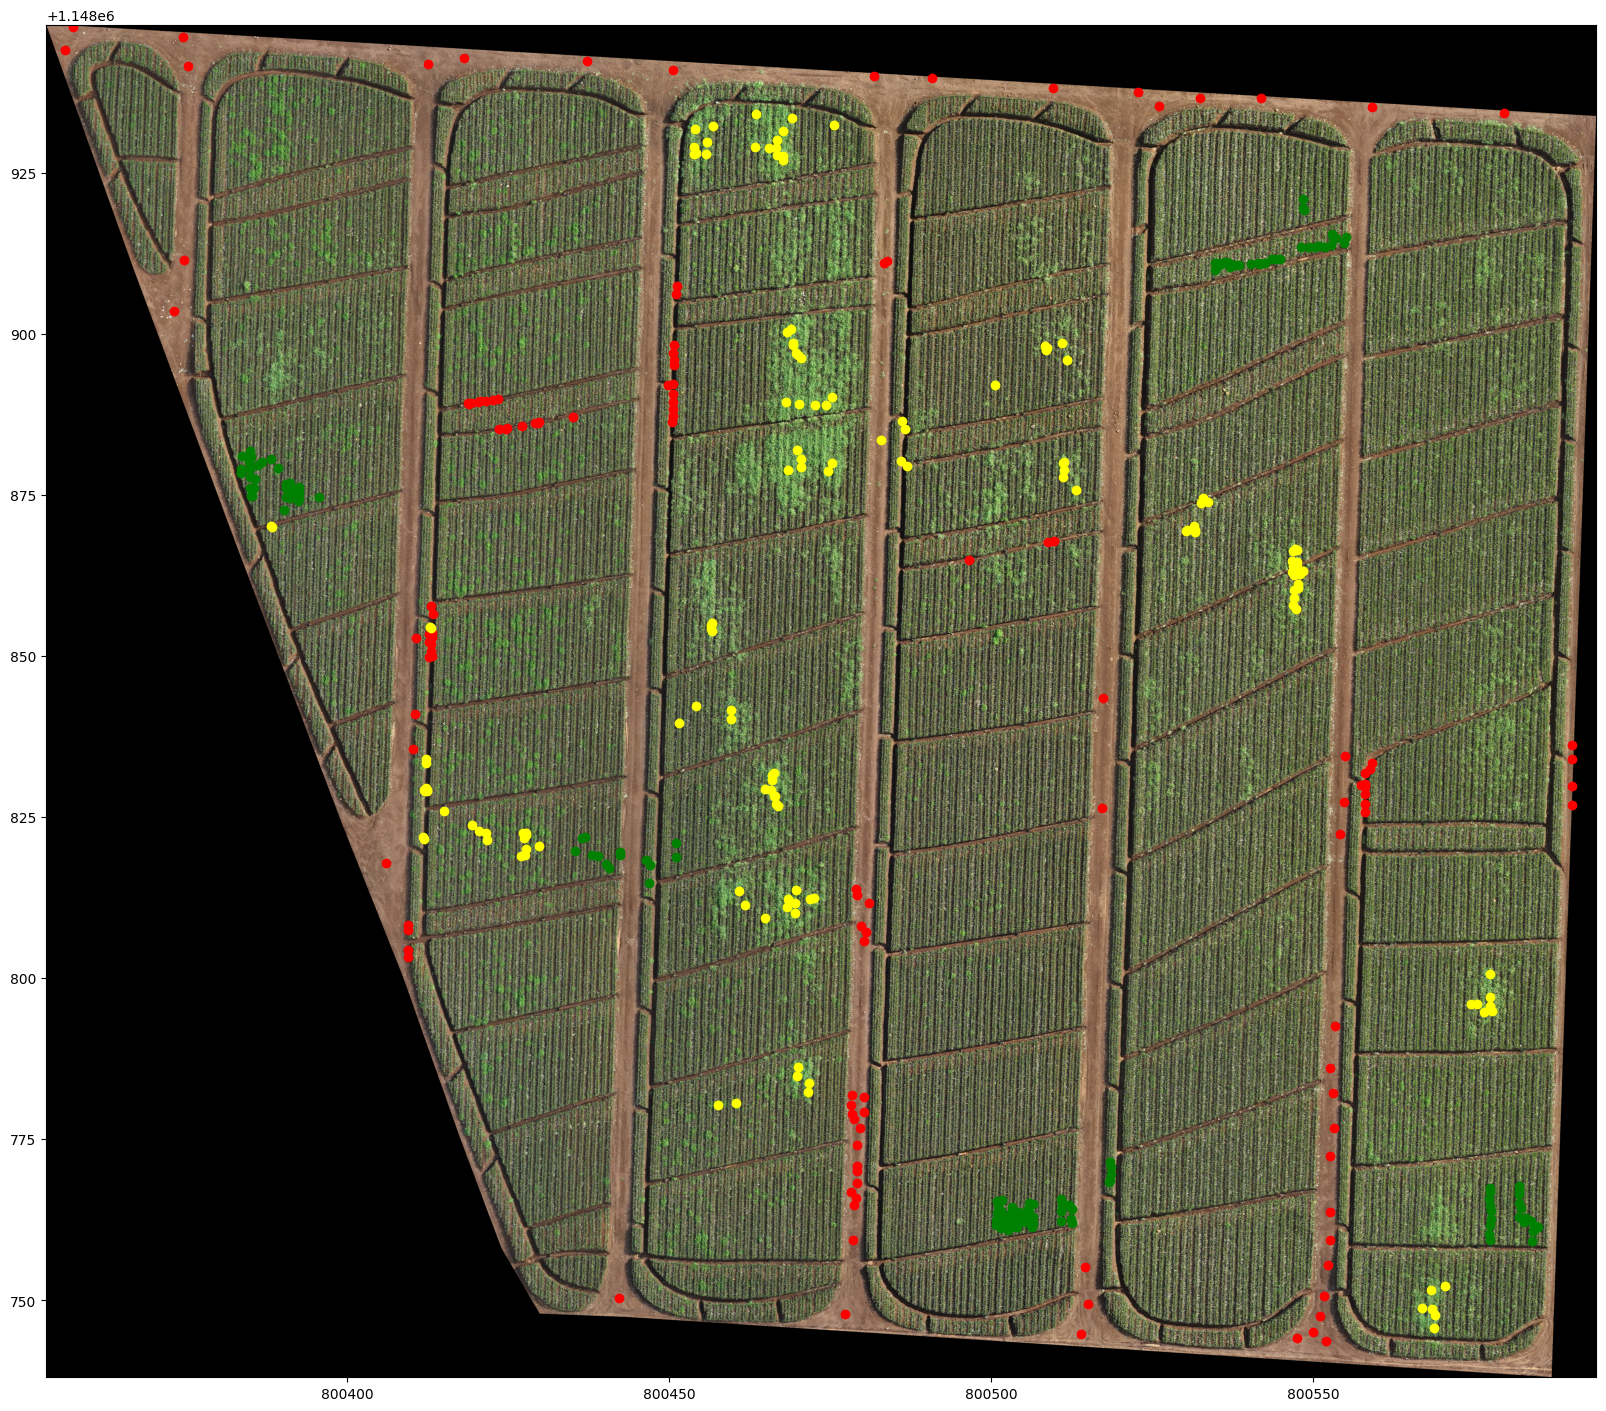

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
with rasterio.open(path_img) as src:
    gdf1 = gdf1.to_crs(src.crs.to_dict())
    gdf2 = gdf2.to_crs(src.crs.to_dict())
    gdf3 = gdf3.to_crs(src.crs.to_dict())
    show(src,ax=ax)
gdf1.plot(ax=ax, color='red')
gdf2.plot(ax=ax, color='green')
gdf3.plot(ax=ax, color='yellow')

Now we add an id to each of the classes:

In [ ]:
gdf1['id'] = 0
gdf2['id'] = 1
gdf3['id'] = 2

Let's concatenate the point geodataframes and extract the spectral values ​​from the image at each point:

In [ ]:
gdf = pd.concat([gdf1,gdf2,gdf3], axis=0)

In [ ]:
coord_list = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]

In [ ]:
Values_list = []
Column_list = []
with rasterio.open(path_img) as src:
  Values = [x for x in src.sample(coord_list)]
  Values_list.append(Values)

In [ ]:
X = np.array(Values_list)
X = X[0].copy()
X = X[:,0:3].copy()

Now we have the X variable with the spectral data and the Y variable with the reference data:

In [ ]:
Y = gdf['id'].values
Y = Y[:,np.newaxis]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

Since we are working with categorical data, we need to encode categorical values ​​into binary values ​​so that they are compatible with the expected outputs of a neural network:

In [ ]:
enc = OneHotEncoder()

enc.fit(Y)

Y = enc.transform(Y).toarray()

In [ ]:
Y.shape

(431, 3)

So we split the data into training and testing:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
input_shape = (X_train.shape[1:])
num_classes = len(np.unique(gdf['id'].values))

In [ ]:
input_shape

(3,)

In [ ]:
num_classes

3

So let's build our neural network by adding the dense layers:

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               1024      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 3)                 27        
                                                                 
Total params: 42723 (166.89 KB)
Trainable params: 42723 (166.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


And finally, train the model for 400 iterations:

In [ ]:
history = model.fit(X_train, Y_train, epochs=400, batch_size=250, verbose=1, validation_split=0.25)

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 6.1135 - accuracy: 0.3778 - val_loss: 2.8328 - val_accuracy: 0.3026
Epoch 2/400
1/1 [==============================] - 0s 35ms/step - loss: 3.3282 - accuracy: 0.2533 - val_loss: 3.4607 - val_accuracy: 0.3816
Epoch 3/400
1/1 [==============================] - 0s 36ms/step - loss: 3.9931 - accuracy: 0.3778 - val_loss: 2.1391 - val_accuracy: 0.4079
Epoch 4/400
1/1 [==============================] - 0s 36ms/step - loss: 2.3758 - accuracy: 0.4000 - val_loss: 1.0976 - val_accuracy: 0.3947
Epoch 5/400
1/1 [==============================] - 0s 34ms/step - loss: 1.0059 - accuracy: 0.4622 - val_loss: 1.8658 - val_accuracy: 0.4211
Epoch 6/400
1/1 [==============================] - 0s 33ms/step - loss: 1.7168 - accuracy: 0.4400 - val_loss: 1.6983 - val_accuracy: 0.5658
Epoch 7/400
1/1 [==============================] - 0s 34ms/step - loss: 1.5656 - accuracy: 0.5511 - val_loss: 1.0291 - val_accuracy: 0.6053
Epoch 8/400
1/1 [=====

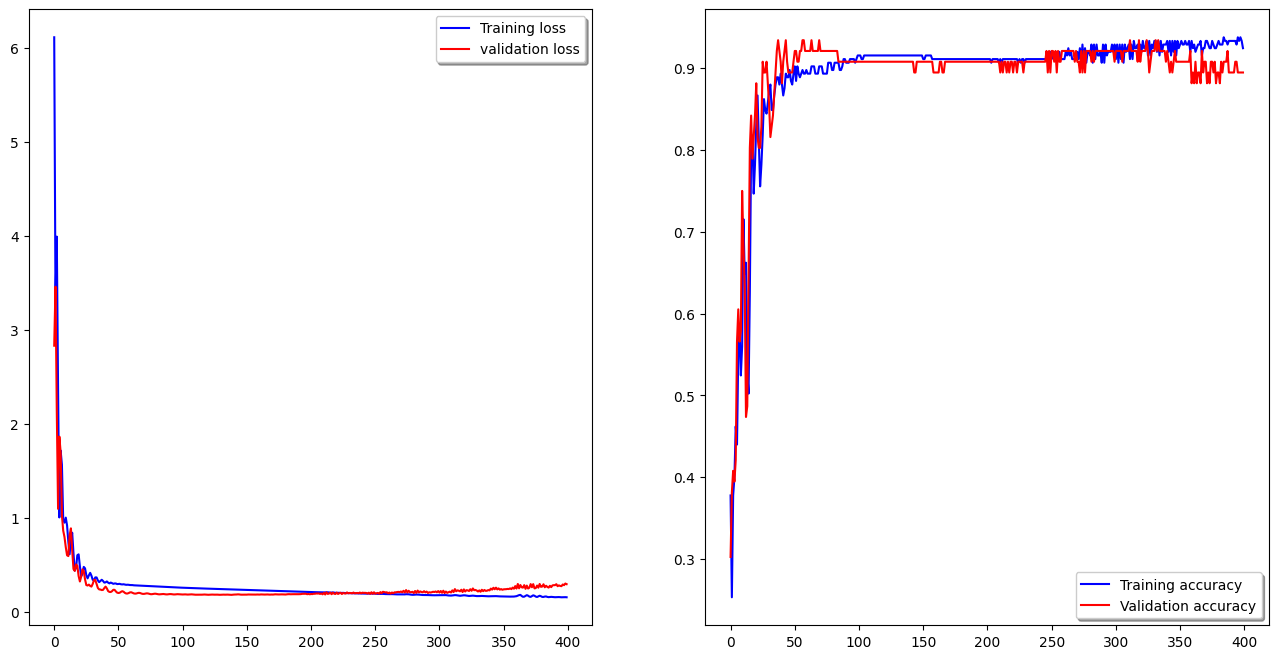

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Let's look at some model evaluation metrics:

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20202559232711792
Test accuracy: 0.9230769276618958


In [ ]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [ ]:
y_pred_res = np.argmax(y_pred, axis=1)

In [ ]:
Y_test_res = np.argmax(Y_test, axis=1)

In [ ]:
print(classification_report(Y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.85      0.89      0.87        38
           2       0.90      0.86      0.88        43

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.92       130
weighted avg       0.92      0.92      0.92       130



In [ ]:
c_matrix = confusion_matrix(Y_test_res, y_pred_res)

In [ ]:
names = ['Solo','Vegetação','Daninhas']

Text(0.5, 58.7222222222222, 'Predict')

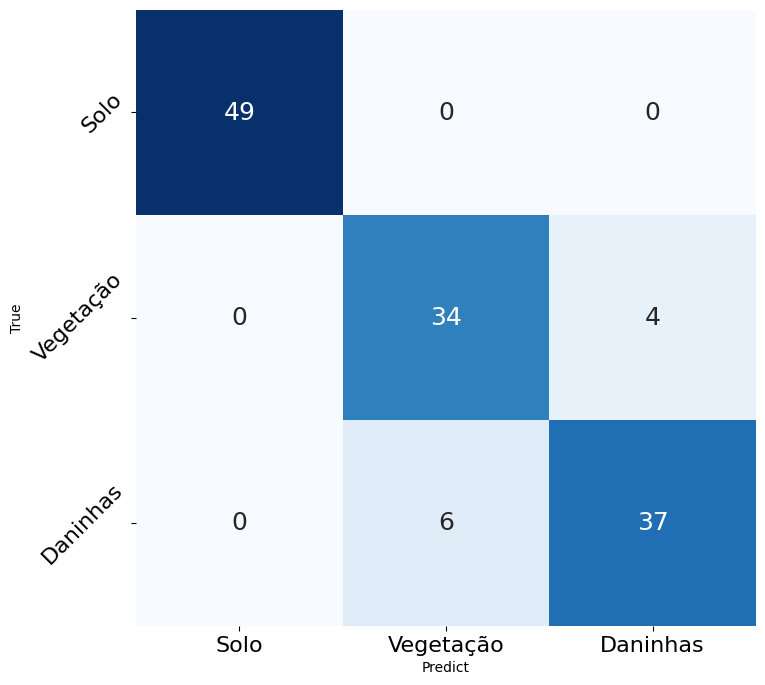

In [ ]:
r1 = pd.DataFrame(data=c_matrix, index= names, columns=names)
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(r1, annot=True, annot_kws={"size": 18},fmt='d',cmap="Blues", cbar = False)
ax.tick_params(labelsize=16)
ax.set_yticklabels(names, rotation=45)
ax.set_ylabel('True')
ax.set_xlabel('Predict')

After training and validating our AI model, we will now apply it to the complete image, thus generating a map with the predictions:

In [ ]:
src = rasterio.open(path_img)
img = src.read()

In [ ]:
img = img.transpose([1,2,0])
img_size = (img.shape[0] , img.shape[1])
img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
img.shape

(51650802, 4)

After opening the image, let's create a dataframe with the spectral information and the alpha band:

In [ ]:
df = pd.DataFrame(img, columns=['R','G','B','Mask'])

In [ ]:
del img, src

We will remove the non-valid values ​​using the alpha band:

In [ ]:
df_to_pred = df[df['Mask'] == 255].copy()
values_to_pred = df_to_pred.values[:,0:3]

In [ ]:
df_to_pred.drop(columns={'R', 'G', 'B'}, inplace = True)
df.drop(columns={'R', 'G', 'B'}, inplace = True)

Now we apply the model to the values ​​to obtain the predictions:

In [ ]:
pred = model.predict(values_to_pred)

1251127/1251127 [==============================] - 1999s 2ms/step


With the predicted values, we join them to the complete image dataframe by index:

In [ ]:
pred = np.argmax(pred, axis=1).copy()
df_to_pred['pred'] = pred

In [ ]:
del pred, values_to_pred, model

In [ ]:
df = pd.merge(df,df_to_pred, how='left', left_index=True, right_index=True)

In [ ]:
del df_to_pred

So we have the predictions and we can convert them to the original image size:

In [ ]:
values_to_export = df['pred'].values

In [ ]:
del df

In [ ]:
classify = values_to_export.reshape(img_size)
export_image = classify[np.newaxis,:,:]

Finally, we save the predicted image data with the georeferencing of the RGB image used:

In [ ]:
export_image.dtype

dtype('float64')

In [ ]:
src = rasterio.open(path_img)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": export_image.shape[1],
                  "width": export_image.shape[2],
                  "compress":'lzw',
                  "nodata": np.nan,
                  "dtype": 'float64',
                  "count":1
                  })

In [ ]:
with rasterio.open('/content/mapa.tif', "w", **out_meta) as dest:
     dest.write(export_image)

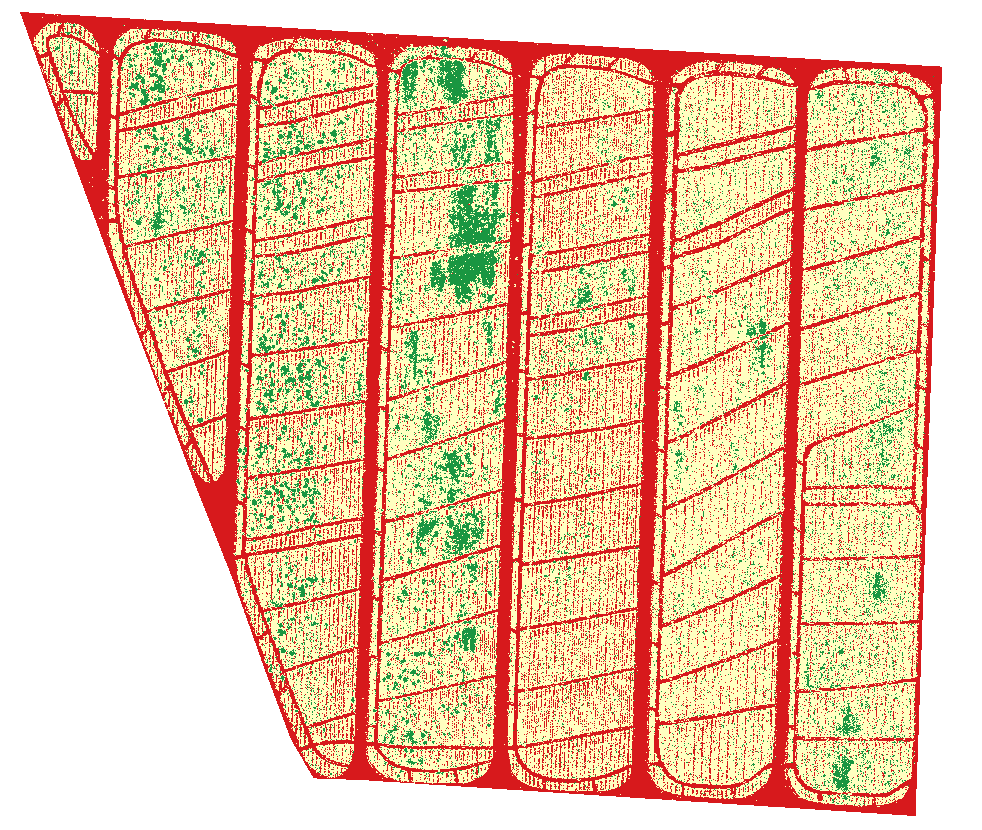